# Data Source
* [Famine](https://web.archive.org/web/20170802193952/http://fletcher.tufts.edu/World-Peace-Foundation/Program/Research/Mass-Atrocities-Research-Program/Mass-Famine#Dataset)

# Data Preparation

In [1]:
# Get all necessary packages
import pandas as pd
import os
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in and check file
famine = pd.read_csv("data" + os.sep + "famine" + os.sep + "famine.csv", sep = ",")
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,NaN,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,NaN,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,NaN,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,NaN,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,NaN,India,"Drought, colonialism",6m,6000000,NaN,"Davis, 2002"
3,1876-79,1876,1876,NaN,Brazil,"Drought, economic crisis",500000,500000,NaN,"Cunniff, 1970"
4,1885-99,1885,1899,NaN,Congo,"Colonialism, forced labor",3m,3000000,NaN,"Hochschild, 1998; Acherson 1999"


In [3]:
# Calculate duration 
# Add one to avoid duration of 0
famine["Duration"] = (famine["End Year"]+1) - famine["Start Year"]
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,2,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,NaN,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,4,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,NaN,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,10,India,"Drought, colonialism",6m,6000000,NaN,"Davis, 2002"
3,1876-79,1876,1876,1,Brazil,"Drought, economic crisis",500000,500000,NaN,"Cunniff, 1970"
4,1885-99,1885,1899,15,Congo,"Colonialism, forced labor",3m,3000000,NaN,"Hochschild, 1998; Acherson 1999"


In [4]:
# Calculate death per year
famine["Death per Year"] = famine["Mean Death"] / famine["Duration"]
famine.head()

,Date Range,Start Year,End Year,Duration,Country,Cause,Range Death,Mean Death,Death per Year,Source
0,1870-71,1870,1871,2,Persia,"Economic crisis, drought","500,000-1.5 million",1000000,500000.0,"Foran 1989, Okasaki 1986"
1,1876-1879,1876,1879,4,"China (Shanxi, Henan, Shandong, Zhili, and Sha...","Drought, lack of state capacity due to rebelli...",9m,9000000,2250000.0,"Edgerton-Tarpley, 2008; Fuller, 2015; Davis, 2..."
2,1870s,1870,1879,10,India,"Drought, colonialism",6m,6000000,600000.0,"Davis, 2002"
3,1876-79,1876,1876,1,Brazil,"Drought, economic crisis",500000,500000,500000.0,"Cunniff, 1970"
4,1885-99,1885,1899,15,Congo,"Colonialism, forced labor",3m,3000000,200000.0,"Hochschild, 1998; Acherson 1999"


Text(0.5, 0, 'Death per year')

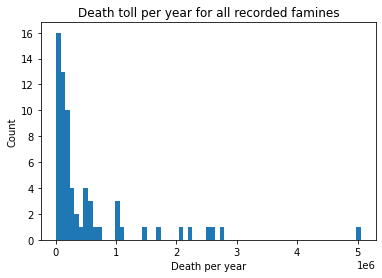

In [32]:
# Plot death per year
ax = famine["Death per Year"].sort_values(ascending=False).plot(kind="hist", bins= len(famine.index))
ax.set_title("Death toll per year for all recorded famines")
ax.set_ylabel("Count")
ax.set_xlabel("Death per year")

# Prepare for fitting

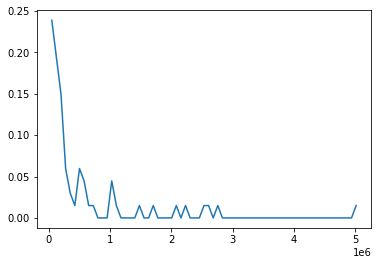

In [29]:
# Bin the data
density, death_per_year = np.histogram(famine["Death per Year"], bins = len(famine.index), density=1)
# adjust the denisty to the bin width (https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1)
density = density*np.diff(death_per_year)
# calculate the bin means
death_per_year = np.array([0.5 * (death_per_year[i] + death_per_year[i+1]) for i in range(len(death_per_year)-1)])
# plot
plt.plot(death_per_year, density)

# Fit to Power Law

In [30]:
# Fit data to power law
def powerlaw(x,exponent):
    return (x**exponent)/np.min(x)**exponent
params, covar = curve_fit(powerlaw, death_per_year, density)
params

array([-1.57879647])

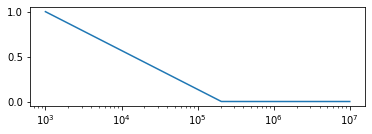

In [52]:
# Plot the power law
x_sim = np.linspace(1000,10000000)
y_sim = powerlaw(x_sim, params[0])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim)
ax.set_xscale("log")

In [50]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000])
probs = powerlaw([amount_dead],params[0])
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[0][i]))

Dead: 1
Prob of this many dead: 1.0
Dead: 10
Prob of this many dead: 0.02637567197512913
Dead: 100
Prob of this many dead: 0.0006956760721396122
Dead: 1000
Prob of this many dead: 1.834892387970068e-05
Dead: 10000
Prob of this many dead: 4.839651973475989e-07
Dead: 100000
Prob of this many dead: 1.2764907292618904e-08
Dead: 1000000
Prob of this many dead: 3.366830075430499e-10
Dead: 10000000
Prob of this many dead: 8.880240566555412e-12
Dead: 100000000
Prob of this many dead: 2.342223122437004e-13


# Fit to lognormal